In [ ]:
#Open_CP
!pip install https://github.com/QuantCrimAtLeeds/PredictCode/zipball/master
#SEPP
!pip install https://github.com/MatthewDaws/SEPP/zipball/master

# Función de entrenamiento y predicción del crimen para Villavicencio

POR: Diego Alejandro Hernández Castañeda, Juan Sebastian Cañas Silva, PhD Francisco Albeiro Gomez Jaramillo

COMBIOS RESEARCH GROUP


In [2]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import datetime
import numpy as np
import pyproj
import dateutil.parser
import descartes
import math
import csv

import matplotlib.pyplot as plt
import matplotlib.collections

#Imporante: Librerias creadas por QuantCrimAtLeeds grupo de investigacion crimen de la universidad de Leeds U.K.
#https://github.com/QuantCrimAtLeeds/PredictCode
import open_cp
import open_cp.plot
import open_cp.geometry
import open_cp.predictors
import open_cp.sources.sepp

import open_cp.seppexp as seppexp
from open_cp import evaluation
import open_cp.sepp as sepp

# Funcion de selección datos entrenamiento:

In [3]:
"""
Funcion Data: permite filtrar la BD de los delitos, y la comuna de interes.

Resumen de variables entrada:
    delito: tipo texto, opciones en las bases de datos: Rina, Homicidio.
    n_comuna: Tipo entero, define el numero de la comuna entre 1,..,8
    opcion: variable entera, es una variable auxiliar que varia al final del codigo, los elementos retornados
"""

def Data(delito, n_comuna, opcion):
    df = pd.read_csv('Delitos_Comunas_3116.csv',encoding = 'latin-1')
    
    #Filtro por tipo de delito, hay que seleccionar entre: "Hurto", "Rina", "Homicidio"
    frame = df[(df.TIPO == delito)]
    comuna ='Comuna '+str(n_comuna)
    
    #Seleccionando de la lista anterior el cuadrante que se quiere
    frame = frame[(frame.Nombre_Cua == comuna)]

    # Ajuste datos tiempo formato para SEPP
    timestamps = frame.FYH.map(dateutil.parser.parse)

    #Proyeccion a coordenadas planas, pues SEPP trabaja sobre coordenadas en metros. EPSG 3116 o 3117 colombia centro o bogota centro
    #proj = pyproj.Proj(init="EPSG:3116")
    #Activo si hay que proyectar de geograficas a planas------------------------------------------------
    #xcoords, ycoords = proj(frame.LONGITUD.values, frame.LATITUD.values)
    #Activo si no hay que proyectar porque esta en planas ----------------------------------------------
    
    xcoords, ycoords = (frame.X.values, frame.Y.values)

    #Uniendo coordenadas y formato de tiempo creado asociado a cada crimen
    points = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    
    #Cargando el shp de comuna y trabajando unicamente sobre la comuna de interes
    frame2 = gpd.read_file("shp\Comunas_3116.shp")
    frame2= frame2[frame2.Nombre_Cua.isin([comuna])]
    geo = list(frame2.geometry)[0]
    
    #Generando Grilla para los algoritmos. 
    maxx = max(xcoords)
    minx = min(xcoords)
    maxy = max(ycoords)
    miny = min(ycoords)

    region = open_cp.RectangularRegion(xmin=minx, xmax=maxx, ymin=miny, ymax=maxy)

    #Ventana espacial 150x150 metros unicamente por testeo
    grid = open_cp.data.Grid(xsize=150, ysize=150, xoffset=min(xcoords), yoffset=min(ycoords))
    grid2 = open_cp.geometry.mask_grid_by_intersection(geo, grid)
    
    if (opcion==1):
        return (points, grid2, geo, region)
    if (opcion==2):
        return (grid2, geo, region)

In [4]:
"""
Prediction_correction: permite modificar la matriz de prediccion dada por el modelo SEEP. Cambia los valores 
                        de la prediccion por -1 si la cuadricula esta por fuera de la comuna que se analiza.
                        
Resumen de variables entrada:
    grid: Grilla generada para el procesamiento interno del programa.
    geo: es la geometria shp de la comuna seleccionada.
    prediction: es la matriz nxn de las predicciones sobre la comuna seleccionada.
"""

def Prediction_correction(grid, geo, prediction):
    
    mix = grid.xoffset
    miy = grid.yoffset
    xcoord = []
    ycoord = []
    matrix_r = np.array(prediction.intensity_matrix)
    for x in range(0,len(prediction.mesh_data()[0])-1):
        for y in range(0,len(prediction.mesh_data()[1])-1):
            xx = grid.grid_coord(prediction.mesh_data()[0][x],prediction.mesh_data()[1][y])
            
            #Aqui se generaran los 4 puntos (o esquinas) que describen un cuadro dentro de la cuadricula
            p1 = Point(xx[0]*150+mix, xx[1]*150+miy)
            p2 = Point(xx[0]*150+mix+150, xx[1]*150+miy)
            p3 = Point(xx[0]*150+mix, xx[1]*150+miy+150)
            p4 = Point(xx[0]*150+mix +150, xx[1]*150+miy+150)
            
            #Aqui se determina si alguno de los 4 puntos estan en el shp de la comuna.
            if (p1.within(geo)==False and p2.within(geo)==False and p3.within(geo)==False and p4.within(geo)==False):
                matrix_r[y][x] = -1
                xcoord.append(xx[0]*150+mix)
                ycoord.append(xx[1]*150+miy)
    return (matrix_r, xcoord, ycoord)

In [5]:
import geojson
import numpy as np

def saveGeojson(coordx,coordy,predicM,fileName,comuna_id,predict_date_gral):
    dataPol = [];
    dbId = 1;
    
    
    for hora in range(0, 24):  
        prediction_date = datetime.datetime(
            year = predict_date_gral.year,
            month = predict_date_gral.month,
            day = predict_date_gral.day)+datetime.timedelta(hours=hora)
        #prediction_date = str(prediction_date_gral)+'-'+str(hora)
        predic = predicM[hora].intensity_matrix
        print(type(predic))
        predic = 255*((predic-np.min(predic))/(np.max(predic)-np.min(predic)))
        
        #fileName = 'Predic_Comuna_'+str(comuna)+'_fecha_'+str(prediction_date)
        for i in range(coordx.size-1):
            for j in range(coordy.size-1):
                x0 = coordx[i];
                y0 = coordy[j];
                x1 = coordx[i+1];
                y1 = coordy[j+1];
                if predic[j][i]>10:
                    centroid_x = (x0+x1)/2.0;
                    centroid_y = (y0+y1)/2.0;
                    data1 = { "type": "Feature", "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ x0, y0 ], [ x0,y1 ], [ x1,y1 ], [ x1,y0 ], [ x0,y0 ] ] ] ] }, "properties": {"cartodb_id" : dbId, "intensity_val": predic[j][i],"comuna_id":comuna_id,"prediction_date":prediction_date.isoformat(),"centroid_x":centroid_x,"centroid_y":centroid_y} };
                    dbId = dbId+1;
                    dataPol.append(data1);

    fc = geojson.FeatureCollection(dataPol)

    with open("json/tmp.json", 'w') as outfile:
        geojson.dump(fc, outfile)

    a = '{"crs": {"type": "name", "properties": {"name": "EPSG:3116"}},'
    f = open("json/tmp.json","r")
    stringVal = f.read()
    f.close()
    text_file = open('json/'+fileName, "w")    
    text_file.write(a+stringVal[1:])
    #text_file.write(stringVal)
    text_file.close()

In [6]:
import geojson
import numpy as np

def savemonoGeojson(coordx,coordy,predic,fileName,comuna_id,prediction_date):
    predic = 255*((predic-np.min(predic))/(np.max(predic)-np.min(predic)))
    dataPol = [];
    dbId = 1;
    for i in range(coordx.size-1):
        for j in range(coordy.size-1):
            x0 = coordx[i];
            y0 = coordy[j];
            x1 = coordx[i+1];
            y1 = coordy[j+1];
            if predic[j][i]>10:
                centroid_x = (x0+x1)/2.0;
                centroid_y = (y0+y1)/2.0;
                data1 = { "type": "Feature", "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ x0, y0 ], [ x0,y1 ], [ x1,y1 ], [ x1,y0 ], [ x0,y0 ] ] ] ] }, "properties": {"cartodb_id" : dbId, "intensity_val": predic[j][i],"comuna_id":comuna_id,"prediction_date":prediction_date,"centroid_x":centroid_x,"centroid_y":centroid_y} };
                dbId = dbId+1;
                dataPol.append(data1);

    fc = geojson.FeatureCollection(dataPol)

    with open("tmp.json", 'w') as outfile:
        geojson.dump(fc, outfile)

    a = '{"crs": {"type": "name", "properties": {"name": "EPSG:3116"}},'
    f = open("tmp.json","r")
    stringVal = f.read()
    f.close()
    text_file = open(fileName, "w")    
    text_file.write(a+stringVal[1:])
    #text_file.write(stringVal)
    text_file.close()


# Función Validación

In [7]:
"""
Validation: Validación cruzada empleando el SEEP
                        
Resumen de variables entrada:
    delito: tipo texto, opciones en las bases de datos: Rina, Homicidio.
    comuna: Tipo entero, define el numero de la comuna entre 1,..,8
    hotspot_percentage: porcentaje de los hotsposts que se emplearan para el PAI
    coverage: porcentaje del area total de la comuna empleada para el PAI
    
"""

def Validation(delito, comuna, hotspot_percentage, coverage):
    import sepp.sepp_grid
    
    #Creando las csv donde se guardaran los PAIS obtenidos para cada interacion y txt coon informacion de los modelos SEEP
    nsepp = 'sepp '+str(comuna)+'.csv'
    csvsepp=open(nsepp,'w', newline='')
    objsepp=csv.writer(csvsepp)
    text= open(str(comuna)+"_Modelo_Validaciones.txt","w+")
    
    #Cargando los datos, grilla, geometriaa shp, region de la funcion Data
    training_data, grid, geo, region = Data(delito, comuna, 3)
    
    for m in range (1,15):
        
        #Inicio 1------------------------------------------------------------------------------------
        #Aqui se realiza los cortes por semana de la data para realizar la validacion cruzada
        times = training_data.time_range
        time_predicts = times[1] - np.timedelta64(m, 'W')
        score_end_time = time_predicts + np.timedelta64(5, 'D')

        training = training_data[training_data.timestamps < time_predicts]
        mask = (training_data.timestamps > time_predicts) & (training_data.timestamps <= score_end_time)
        eval_pts = training_data[mask]
        #Fin 1---------------------------------------------------------------------------------------

        
        
        #Inicio 2------------------------------------------------------------------------------------
        #Aqui se genera un SEEP para predicciones por semana del modelo de MatthewDaws
        prediction = sepp.sepp_grid.ExpDecayTrainer(grid)
        prediction.data = training_data
    
        n=30
        while True:
            model = prediction.train(time_predicts,iterations=n)
            if(math.isinf(model.omega)==True or math.isinf(model.theta)==True or math.isnan(model.omega)==True or math.isnan(model.theta)==True):
                n=n-1
            else:
                break
                
        n = int(n*(3/4))
        model = prediction.train(time_predicts,iterations=n)            
        prediction = prediction.prediction_from_background(model)
        #Fin 2---------------------------------------------------------------------------------------
        
        
        
        #Inicio 3------------------------------------------------------------------------------------
        #Aqui se generan los PAIS y se guardan en los csv y alguna informacon adicional en los txt
        coverages = list(range(0, hotspot_percentage+1))
        hitrates = open_cp.evaluation.hit_rates(prediction, eval_pts, coverages)
        pai = np.zeros(len(hitrates))
        
        for i in range(len(hitrates)):
            pai[i] = hitrates[i]/(hotspot_percentage/100)
        
        if(int(pai[i])<=0):
            text.write("Modelo de validacion numero:  %d\r\n" % m)
            text.write("Fechas de entrenamiento: "+str(time_predicts)+" "+str(score_end_time))
            text.write("\n")
            text.write("Numero datos entrenamiento: "+str(len(training.timestamps )))
            text.write("\n")
            text.write("Modelo omitido por falta de datos para validacion: "+str(len(training.timestamps )))
            text.write("\n \n")
            continue
        objsepp.writerow(pai)
            
        text.write("Modelo de validacion numero:  %d\r\n" % m)
        text.write("Fechas de entrenamiento: "+str(time_predicts)+" "+str(score_end_time))
        text.write("\n")
        text.write("Numero datos entrenamiento: "+str(len(training.timestamps )))
        text.write("\n")
        text.write("Paramentros de modelo: "+str((model.omega, model.theta)))
        text.write("\n \n")
        #Fin 3---------------------------------------------------------------------------------------
        
    
    #Inicio 4------------------------------------------------------------------------------------
    #Aqui se genera el promedio de los PAI'S generados en las 15 iteraciones
    csvsepp.close()
    text.close()
    df = pd.read_csv (nsepp)
    weeks = df.shape
    mean = np.array(df.mean())
        
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(coverages, [mean[x] for x in coverages])
    ax.set(xlabel="% coverage", ylabel="PAI ")
    ax.set_title("Validación modelo SEPP con: "+str(weeks[0])+" Semanas")
    None
    #Fin 4---------------------------------------------------------------------------------------
        
    return (prediction, mean)

## EJEMPLOS DEL USO DE " VALIDACION CRUZADA " Y " ENTRENAMIENTO "


##### SEPP VALIDACIÓN
Aqui se muestra el desempeño del algoritmo SEPP para predicciones mediante validación cruzada

In [ ]:
# Entrenamiento y validacion con los datos 

sepp_validation = Validation("Hurto", 8, 20, 20)

## SEPP PREDICCION
Ingresando la fecha que desea hacer la prediccion


In [15]:
#Datos de entrada para cargar modelo entrenado y para genrar predicciones sobre la fecha y hora deseada
año = int(input('Ingrese año: '))
mes = int(input('Ingrese mes: '))
dia = int(input('Ingrese dia: '))
hora = int(input('Ingrese hora: '))
predict_time = datetime.datetime(año,mes,dia)+datetime.timedelta(hours=hora)
predict_time

Ingrese año: 2019
Ingrese mes: 7
Ingrese dia: 6
Ingrese hora: 20


datetime.datetime(2019, 7, 6, 20, 0)

#### ¡IMPORTANTE! ingrese la comuna y el tipo de delito sobre el cual quiere la predicción

In [18]:
comuna = int(input('Ingrese numero de comuna (1-8): '))
delito = input('Ingrese tipo delito "Hurto" o "Rina": ')

Ingrese numero de comuna (1-8): 2
Ingrese tipo delito "Hurto" o "Rina": Hurto


In [19]:
#Cargando el pkl del modelo entrenado
import pickle
pkl='pkl/Train'+str(delito)+str(comuna)+'.pkl'
infile = open(pkl,'rb')
Train = pickle.load(infile)
infile.close()

In [20]:
#Cargando datos geograficos para graficar
grid, geo, region = Data(delito, comuna, 2)

#Generando las predicciones para la fecha desesada
prediction = Train.predict(predict_time)
gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 150, 150)

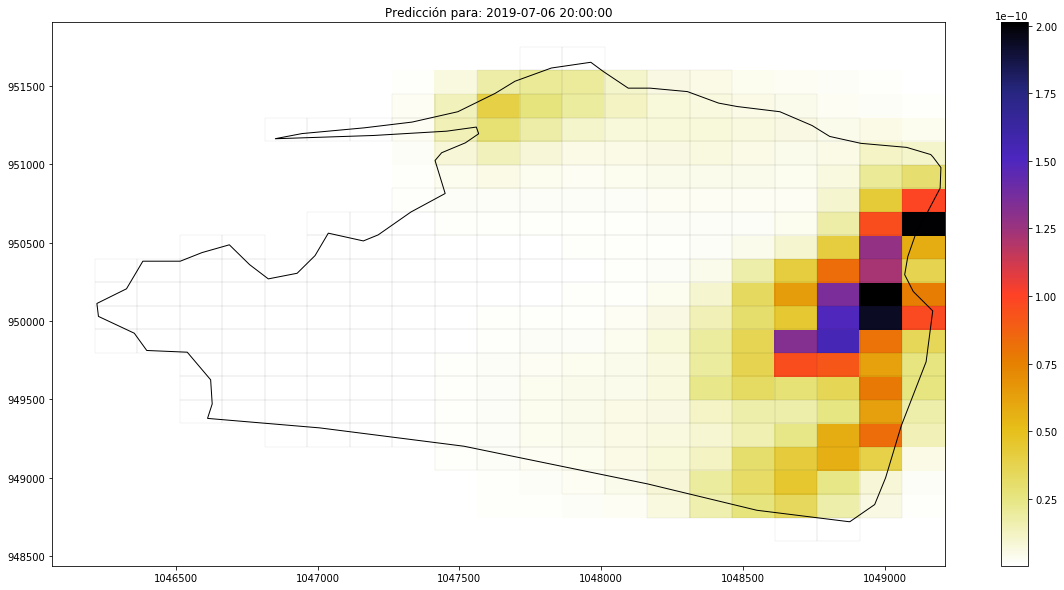

In [21]:
#Graficando
from PIL import Image


fig, ax = plt.subplots(figsize=(20,10))
lc = matplotlib.collections.LineCollection(open_cp.plot.lines_from_grid(grid), color="black", linewidth=0.05)
ax.add_collection(lc)
ax.add_patch(descartes.PolygonPatch(geo, fc="none"))
m = ax.pcolormesh(*gridpred.mesh_data(), gridpred.intensity_matrix, cmap="CMRmap_r")
ax.set_title("Predicción para: "+str(predict_time))
fig.colorbar(m, ax=ax)
None

In [84]:
#Guardando en un .json el archivo de predicciones 
#name =str(delito)+str(comuna)+'-'+str(año)+'-'+str(mes)+'-'+str(dia)+'-'+str(hora)
prediction_date = str(año)+'-'+str(mes)+'-'+str(dia)+'-'+str(hora)
fileName = 'Prediccion'+str(comuna)+'_fecha_'+str(prediction_date)
savemonoGeojson(gridpred.mesh_data()[0],gridpred.mesh_data()[1],gridpred.intensity_matrix,fileName,comuna,prediction_date)

### Predicciones Multiples

In [89]:
#Cargando datos geograficos para graficar
grid, geo, region = Data(delito, comuna, 2)
predict_time = predict_time+datetime.timedelta(hours=0)


#Generando las predicciones para la fecha desesada para ventanas de 1 hora
dates = [predict_time + datetime.timedelta(hours=1*i) for i in range(24)]
predictions = [Train.predict(d) for d in dates]
gridpred = [open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(pr, region, 150, 150) for pr in predictions]

In [90]:
saveGeojson(gridpred[0].mesh_data()[0],gridpred[0].mesh_data()[1],gridpred,'Predict_2019_7_5_Rina_Comuna3',comuna,dates[0])
#saveGeojson(gridpred[i].mesh_data()[0],gridpred[i].mesh_data()[1],gridpred[i].intensity_matrix,'archivo2.json',comuna,prediction_date)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [96]:
#Guardando en un pkl las predicciones multiuples hechas
outfile1 = open('pkl/PREDICCIONES_'+delito+'_'+str(año)+'_'+str(mes)+str(dia)+'.pkl','wb')
pickle.dump(gridpred, outfile1)
outfile1.close() 

In [105]:
import pickle
pkl='pkl/PREDICCIONES_'+delito+'_'+str(año)+'_'+str(mes)+str(dia)+'.pkl'
infile = open(pkl,'rb')
gridpred = pickle.load(infile)
infile.close()